In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

In [2]:
import random
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

sns.set_context('paper', font_scale=2, rc={'lines.linewidth': 2})
sns.set_style(style='whitegrid')

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '..')

## Loading dataset

In [20]:
import pandas as pd
import glob

In [36]:
video_df = pd.read_csv('../data/youtube_faces_with_keypoints_large.csv')
video_df.head()

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0


In [32]:
# create a dictionary that maps videoIDs to full file paths
npz_files_full_path = glob.glob('../data/youtube_faces_*/*.npz')
video_ids = [x.split('/')[-1].split('.')[0] for x in npz_files_full_path]

full_paths = {}
for video_id, full_path in zip(video_ids, npz_files_full_path):
    full_paths[video_id] = full_path

# remove from the large csv file all videos that weren't uploaded yet
video_df = video_df.loc[video_df.loc[:,'videoID'].isin(full_paths.keys()),:].reset_index(drop=True)
print('Number of Videos uploaded so far is %d' %(video_df.shape[0]))
print('Number of Unique Individuals so far is %d' %(len(video_df['personName'].unique())))

Number of Videos uploaded so far is 1293
Number of Unique Individuals so far is 374


## Show Overview of Dataset Content (that has been uploaded so far)

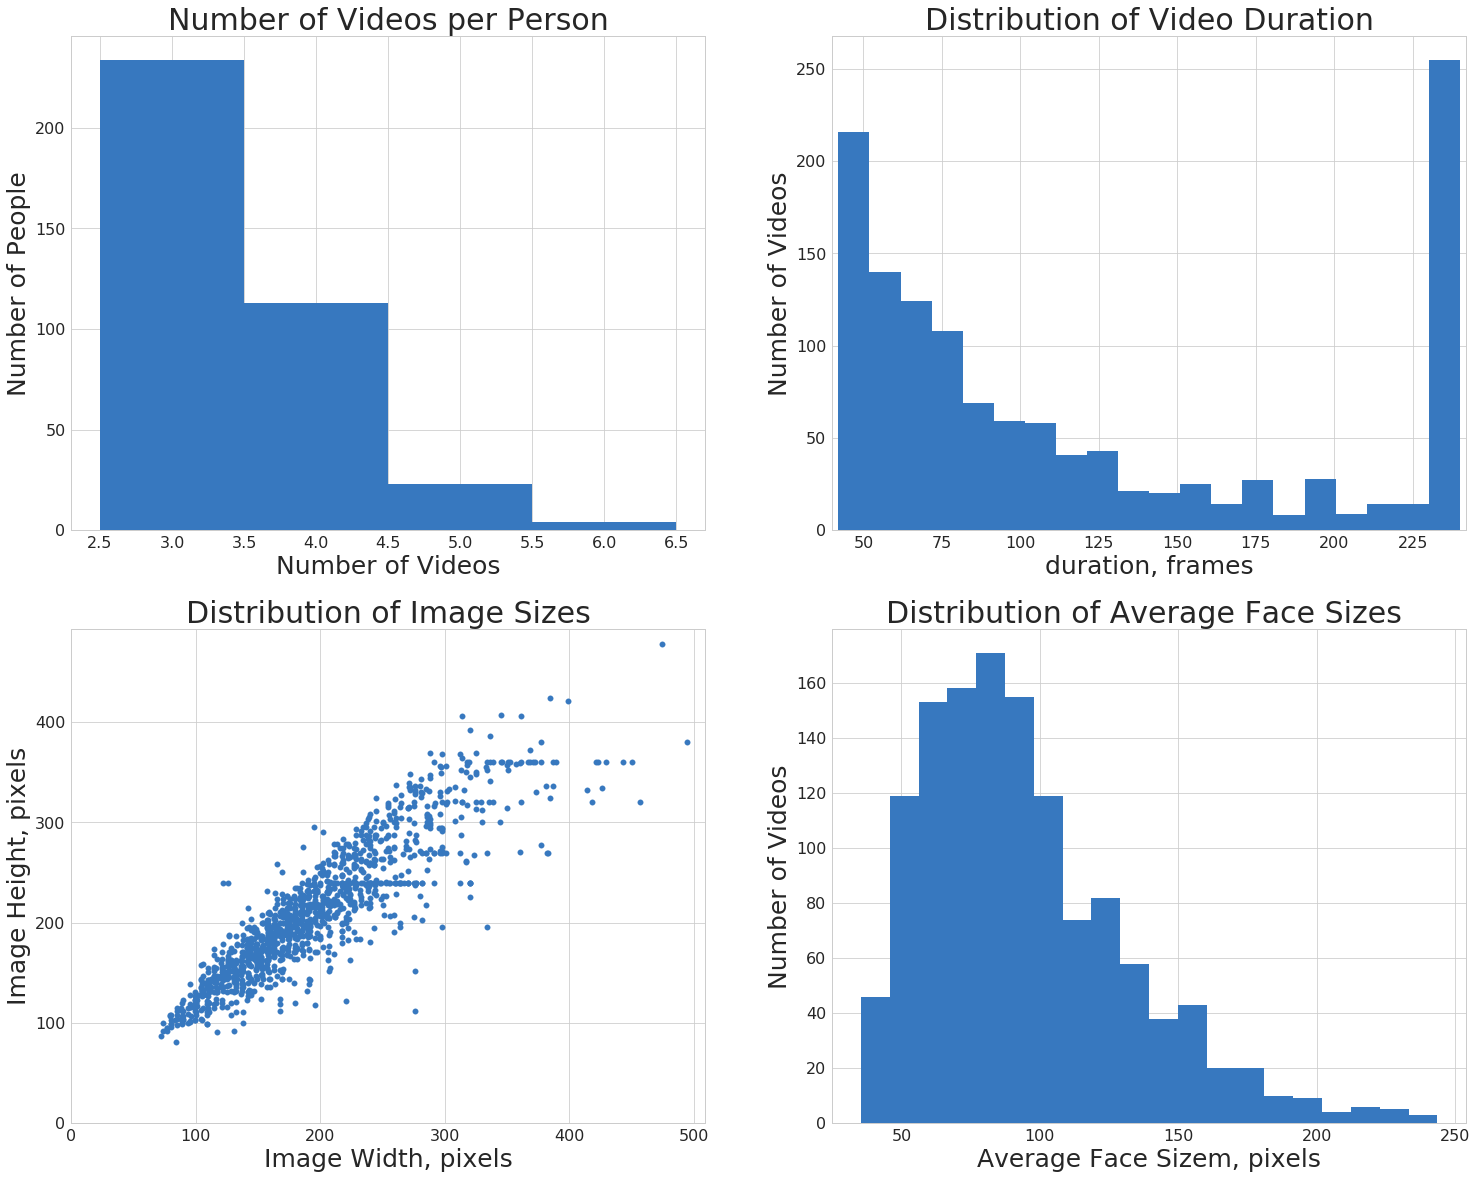

In [34]:
# overview of the contents of the dataset
grouped_by_person = video_df.groupby("personName")
num_videos_per_person = grouped_by_person.count()['videoID']
grouped_by_person.count().sort_values('videoID', axis=0, ascending=False)

plt.close('all')
plt.figure(figsize=(25,20))
plt.subplot(2,2,1)
plt.hist(x=num_videos_per_person,bins=0.5+np.arange(num_videos_per_person.min()-1,num_videos_per_person.max()+1))
plt.title('Number of Videos per Person',fontsize=30); 
plt.xlabel('Number of Videos',fontsize=25); plt.ylabel('Number of People',fontsize=25)

plt.subplot(2,2,2)
plt.hist(x=video_df['videoDuration'],bins=20);
plt.title('Distribution of Video Duration',fontsize=30); 
plt.xlabel('duration, frames',fontsize=25); plt.ylabel('Number of Videos',fontsize=25)
plt.xlim(video_df['videoDuration'].min()-2,video_df['videoDuration'].max()+2)

plt.subplot(2,2,3)
plt.scatter(x=video_df['imageWidth'], y=video_df['imageHeight'])
plt.title('Distribution of Image Sizes',fontsize=30)
plt.xlabel('Image Width, pixels',fontsize=25); plt.ylabel('Image Height, pixels',fontsize=25)
plt.xlim(0,video_df['imageWidth'].max() +15)
plt.ylim(0,video_df['imageHeight'].max()+15)

plt.subplot(2,2,4)
average_face_size_wo_nans = np.array(video_df['averageFaceSize'])
average_face_size_wo_nans = average_face_size_wo_nans[np.logical_not(np.isnan(average_face_size_wo_nans))]
plt.hist(average_face_size_wo_nans, bins=20);
plt.title('Distribution of Average Face Sizes ',fontsize=30);
plt.xlabel('Average Face Sizem, pixels',fontsize=25); plt.ylabel('Number of Videos',fontsize=25);

## Define some shape normalization utility functions

In [35]:
#%% define shape normalization utility functions
def normalize_shapes(shapes_im_coords):
    (numPoints, num_dims, _) = shapes_im_coords.shape
    """shapes_normalized, scale_factors, mean_coords  = NormlizeShapes(shapes_im_coords)"""
    
    # calc mean coords and subtract from shapes    
    mean_coords = shapes_im_coords.mean(axis=0)
    shapes_centered = np.zeros(shapes_im_coords.shape)
    shapes_centered = shapes_im_coords - np.tile(mean_coords,[numPoints,1,1])

    # calc scale factors and divide shapes
    scale_factors = np.sqrt((shapes_centered**2).sum(axis=1)).mean(axis=0)
    shapes_normalized = np.zeros(shapes_centered.shape)
    shapes_normalized = shapes_centered / np.tile(scale_factors, [numPoints,num_dims,1])

    return shapes_normalized, scale_factors, mean_coords


def transform_shape_back_to_image_coords(shapes_normalized, scale_factors, mean_coords):
    """shapes_im_coords_rec = transform_shape_back_to_image_coords(shapes_normalized, scale_factors, mean_coords)"""
    (numPoints, num_dims, _) = shapes_normalized.shape
    
    # move back to the correct scale
    shapes_centered = shapes_normalized * np.tile(scale_factors, [numPoints,num_dims,1])
    # move back to the correct location
    shapes_im_coords = shapes_centered + np.tile(mean_coords,[numPoints,1,1])
    
    return shapes_im_coords

## Show Images from YouTube Faces with 2D Keypoints Overlaid

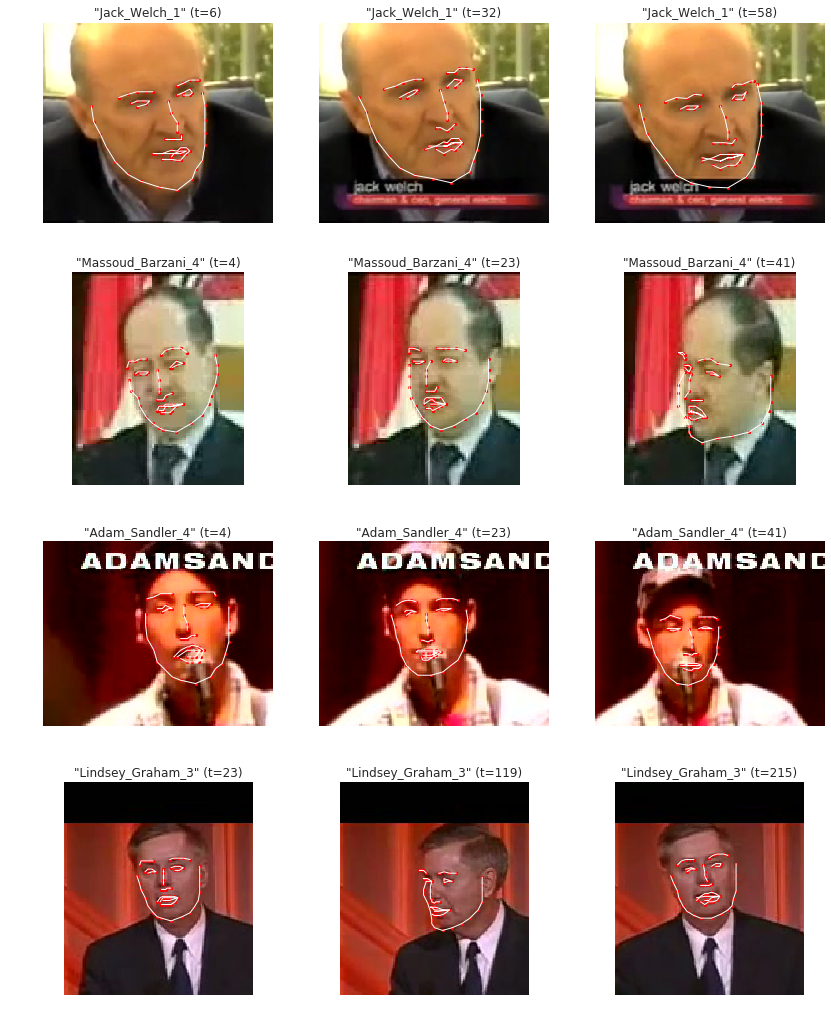

In [42]:
# show several frames from each video and overlay 2D keypoints
np.random.seed(42)
num_videos = 4
frames_to_show_from_video = np.array([0.1,0.5,0.9])
num_frames_per_video = len(frames_to_show_from_video)

# define which points need to be connected with a line
jaw_points          = [ 0,17]
right_eyebrow_points = [17,22]
left_eyebrow_points  = [22,27]
nose_ridge_points    = [27,31]
nose_base_points     = [31,36]
right_eye_points     = [36,42]
left_eye_points      = [42,48]
outer_mouth_points   = [48,60]
inner_mouth_points   = [60,68]

list_of_all_connected_points = [jaw_points,right_eyebrow_points,left_eyebrow_points,
                            nose_ridge_points,nose_base_points,
                            right_eye_points,left_eye_points,outer_mouth_points,inner_mouth_points]

# select a random subset of 'num_videos' from the available videos
rand_videos_id = video_df.loc[np.random.choice(video_df.index,size=num_videos,replace=False),'videoID']

fig, ax_array = plt.subplots(nrows=num_videos,ncols=num_frames_per_video,figsize=(14,18))
for i, video_id in enumerate(rand_videos_id):
    # load video
    video_file = np.load(full_paths[video_id])
    color_images = video_file['colorImages']
    bounding_box = video_file['boundingBox']
    landmarks2D = video_file['landmarks2D']
    landmarks3D = video_file['landmarks3D']

    # select frames and show their content
    selected_frames = (frames_to_show_from_video*(color_images.shape[3]-1)).astype(int)
    for j, frame_idx in enumerate(selected_frames):
        ax_array[i][j].imshow(color_images[:,:,:,frame_idx])
        ax_array[i][j].scatter(x=landmarks2D[:,0,frame_idx],y=landmarks2D[:,1,frame_idx],s=9,c='r')
        for con_pts in list_of_all_connected_points:
            x_pts = landmarks2D[con_pts[0]:con_pts[-1],0,frame_idx]
            y_pts = landmarks2D[con_pts[0]:con_pts[-1],1,frame_idx]
            ax_array[i][j].plot(x_pts,y_pts,c='w',lw=1)
        ax_array[i][j].set_title('"%s" (t=%d)' %(video_id,frame_idx), fontsize=12)
        ax_array[i][j].set_axis_off()